In [1]:
# %load utilities
#!/usr/bin/env python

# In[3]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy.stats import skewtest
from sklearn import metrics

warnings.filterwarnings("ignore")

def romanToInt(i):   
    roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
    j = 0
    num = 0
    while j < len(i):
        if j+1<len(i) and i[j:j+2] in roman:
            num+=roman[i[j:j+2]]
            j+=2
        else:

            num+=roman[i[j]]
            j+=1
    return num

def skew_df(df):
    skewness, p_value = skewtest(df)
    dskew=pd.DataFrame(np.round(np.vstack((skewness.T,p_value.T)),2),columns=df.columns,
                    index=['skewness', 'p_value'])
    return(dskew)

def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'r')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC - TPR vs FPR')
    
def printCustomMetrics(y_test, y_pred):
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(2))
    print("Precision:", metrics.precision_score(y_test, y_pred).round(2))
    print("Recall:", metrics.recall_score(y_test, y_pred).round(2))
    print("f1:", metrics.f1_score(y_test, y_pred).round(2))


In [2]:
#Import Dataset
df = pd.read_csv('loan_default_prediction.csv')
print(df.shape)

(87500, 30)


In [3]:
#drop
vdrop=['ID','Validation','Designation','Debt_to_Income','Postal_Code','Deprecatory_Records',\
            'Inquiries','Gross_Collection','Sub_GGGrade','Total_Unpaid_CL','File_Status','Claim_Type','Due_Fee']
df=df.drop(vdrop,axis=1)
df.shape

(87500, 17)

In [4]:
#Conversão dos anos de experiência para numérico
df['Experience']=df['Experience'].apply(lambda i: 10 if i[0:1]=='>' else 1 if i[0:1]=='<' else int(i[0:1]))
#Conversão da duração para numérico
df['Duration']=df['Duration'].apply(lambda i : i.replace(' years','years')).astype(str)
#Conversão da GGGrade valor ordinal para numérico
df['GGGrade']=df['GGGrade'].apply(romanToInt).astype(int)
#criacao de debt to income
#calcular o total da divida e o rendimento anual. uma espécie de "taxa de esforço"
df['debt_to_income']=df['Unpaid_Amount']/df['Yearly_Income']
#ver resultado
#df.head()

In [5]:
#eliminar observações com pelo menos uma feature sem valores
df=df.dropna()
#drop duplicates
df.drop_duplicates()
df.shape

(77376, 18)

In [6]:
#df.describe()
df.head(5)

,Asst_Reg,GGGrade,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,State,Account_Open,Duration,Unpaid_Amount,Reason,Default,debt_to_income
0,421802,2,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,California,17,3years,31216.05,debt consolidation,0,0.049268
1,3964312,4,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,NC,15,5years,11660.49,debt consolidation,0,0.136407
2,4247560,3,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,Florida,7,5years,5637.87,major purchase,0,0.071185
3,197179,3,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,NewJersey,9,3years,15607.17,major purchase,1,0.253363
4,4646684,5,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,LA,10,5years,27472.86,debt consolidation,0,0.403693


In [7]:
v_num_cont=['Asst_Reg','Experience','Yearly_Income','Lend_Amount','Interest_Charged','Usage_Rate',
            'Present_Balance','Unpaid_Amount','debt_to_income']
v_num_disc=['Unpaid_2_years','Already_Defaulted','Account_Open']
v_cat_ord=['Home_Status','State','Reason','Duration']#,'GGGrade']

In [8]:
from scipy import stats
display(df.shape)
#remover observações com home status 'none' e 'other'
df=df[(df['Home_Status']!='OTHER')&(df['Home_Status']!='NONE')]
#remover linhas com outliers, definidos como mais que 3 desvios-padrão acima/abaixo da média
df=df[(np.abs(stats.zscore(df[v_num_cont])) < 3).all(axis=1)]
df.shape


(77376, 18)

(74542, 18)

# Undersampling

In [9]:
#ver quantas observações têm default=1
display((df['Default']==1).sum())
#sample de 5000 obs com default =1
defaulted = df[df['Default']==1].sample(n=5000, random_state=101)
#sample de 5000 obs com default =0
notdefault = df[df['Default']==0].sample(n=5000, random_state=101)
#agregar as observações
df = pd.concat([defaulted,notdefault],axis=0)
#sort aleatório das obs
df = df.sample(frac=1).reset_index(drop=True)
df.shape

14184

(10000, 18)

In [10]:
df[v_num_disc].describe()

,Unpaid_2_years,Already_Defaulted,Account_Open
count,10000.000000,10000.000000,10000.000000
mean,0.315900,0.005300,12.526900
std,0.855792,0.076632,5.129104
min,0.000000,0.000000,2.000000
25%,0.000000,0.000000,9.000000
50%,0.000000,0.000000,12.000000
75%,0.000000,0.000000,15.000000
max,16.000000,2.000000,51.000000


# Train test split

In [11]:
# Split the data into features (X) and labels (y)
X = df[v_num_cont+v_num_disc+v_cat_ord]
y = df['Default']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Pipelines: transformação de variáveis

In [12]:
#verificar assimetria das features numéricas
dskew=skew_df(X_train[v_num_cont+v_num_disc])
#mostrar output
display(dskew)
#ver lista de features assimétricas, pvalue < 5%
v_skew=list(dskew.columns[dskew.loc['p_value']<0.05])
#lista de simétricas são as restantes
v_sym=list(set(X_train[v_num_cont+v_num_disc].columns) - set(v_skew))
#check
v_skew

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,Account_Open
skewness,13.73,-5.41,38.08,23.12,-0.35,-6.19,34.92,42.01,33.27,73.62,107.71,34.95
p_value,0.00,0.00,0.00,0.00,0.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00


['Asst_Reg',
 'Experience',
 'Yearly_Income',
 'Lend_Amount',
 'Usage_Rate',
 'Present_Balance',
 'Unpaid_Amount',
 'debt_to_income',
 'Unpaid_2_years',
 'Already_Defaulted',
 'Account_Open']

In [13]:
for i in v_cat_ord:
    c=df[i].value_counts()/df.shape[0]
    #list(c[c>.05].index)
    print('Features com predominância em mais de 5% das observações:'+str(list(c[c>=.05].index)))
    print('Features com predominância em menos de 5% das observações:'+str(list(c[c<.05].index)))


Features com predominância em mais de 5% das observações:['MORTGAGE', 'RENT', 'OWN']
Features com predominância em menos de 5% das observações:[]
Features com predominância em mais de 5% das observações:['California', 'TX', 'Newyork', 'Florida']
Features com predominância em menos de 5% das observações:['IL', 'NewJersey', 'PA', 'Ohio', 'GA', 'NC', 'MI', 'VA', 'Maryland', 'AZ', 'CO', 'WA', 'MA', 'MN', 'TN', 'MO', 'NV', 'IN', 'OR', 'SC', 'AL', 'WI', 'CT', 'LA', 'AR', 'KS', 'OK', 'KY', 'UT', 'HI', 'RI', 'NM', 'WV', 'DC', 'NH', 'MS', 'AK', 'MT', 'DE', 'WY', 'SD', 'NE', 'VT', 'ME', 'ND']
Features com predominância em mais de 5% das observações:['debt  consolidation', 'credit  card', 'home  improvement']
Features com predominância em menos de 5% das observações:['other', 'major  purchase', 'medical', 'car', 'small  business', 'moving', 'vacation', 'house', 'wedding', 'RENTwable  energy']
Features com predominância em mais de 5% das observações:['3years', '5years']
Features com predominância 

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Define the transformations to apply to the column
transformer = ColumnTransformer([
    ('yeoj', PowerTransformer(), v_skew), #aplico transformação que corrige assimetria às assimétricas
    ('std', StandardScaler(), v_sym),     #aplico transformação às simétricas (sub média e dividir desvio padrao)
    ('oneh', OneHotEncoder(min_frequency=0.05,handle_unknown='ignore', sparse_output=False), v_cat_ord)
])

# Transform the data
pfit = transformer.fit(X_train)

#Create dataframe with transformation
categories= pfit.transformers_[2][1].categories_
categories_out=pfit.transformers_[2][1].infrequent_categories_

v_onehot_drop=list(np.concatenate([np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0) 
                        for i in range(0,len(categories))],axis=0))


v_onehot=list(np.concatenate([(np.concatenate((np.array(j),
                       (np.array(['Other_Cat'+str(k)]) if categories_out[k] is not None else np.array([]))),axis=0)) 
                         for k,j in enumerate(
                         [np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0) 
                        for i in range(0,len(categories))]
                         )]))

#Transform train and test X
X_train_transf = pd.DataFrame(pfit.transform(X_train),columns = (v_skew + v_sym+v_onehot)
                              ,index=X_train.index)

X_test_transf = pd.DataFrame(pfit.transform(X_test),columns = (v_skew + v_sym+v_onehot)
                            ,index=X_test.index)

display(round(X_train_transf.describe(),2))

#vamos dar um check se o dataframe ficou "menos assimétrico"
skew_df(X_train_transf[v_skew+v_sym])

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,...,Florida,Newyork,TX,Other_Cat1,credit card,debt consolidation,home improvement,Other_Cat2,3years,5years
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,...,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00
mean,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,...,0.07,0.08,0.08,0.63,0.24,0.60,0.05,0.11,0.73,0.27
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.25,0.27,0.27,0.48,0.42,0.49,0.23,0.31,0.45,0.45
min,-2.26,-1.52,-3.87,-2.64,-2.36,-3.87,-3.35,-2.09,-0.49,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.86,-0.83,-0.67,-0.73,-0.72,-0.80,-0.66,-0.76,-0.49,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.01,0.05,0.02,-0.05,0.06,-0.06,-0.04,-0.01,-0.49,-0.07,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00
75%,0.92,1.09,0.67,0.76,0.76,0.85,0.67,0.74,-0.49,-0.07,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00
max,1.48,1.09,2.85,1.98,2.36,2.10,3.25,2.43,2.10,14.29,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,Account_Open,Interest_Charged
skewness,-5.92,-8.84,-0.0,-1.67,-7.25,-2.23,0.91,2.88,42.1,106.08,0.01,-0.35
p_value,0.00,0.00,1.0,0.10,0.00,0.03,0.37,0.00,0.0,0.00,0.99,0.72


# Model Evaluation on test sample

In [15]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve
from sklearn.ensemble import StackingClassifier
import xgboost as xgb


This is the confusion matrix and ROC curve of LogisticRegression


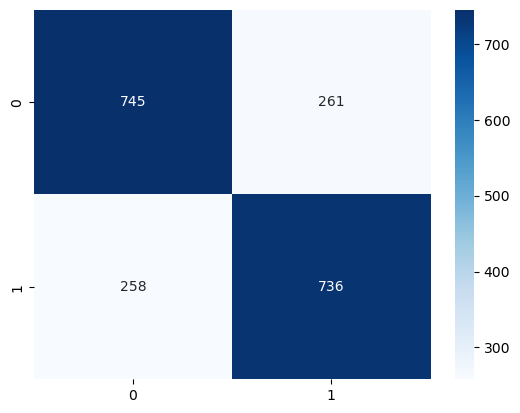

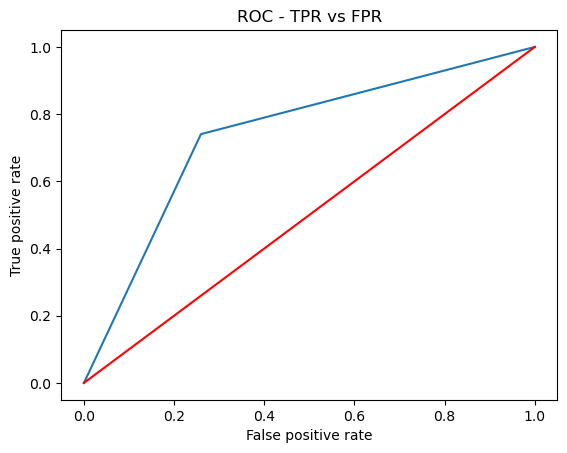

This is the confusion matrix and ROC curve of RandomForestClassifier


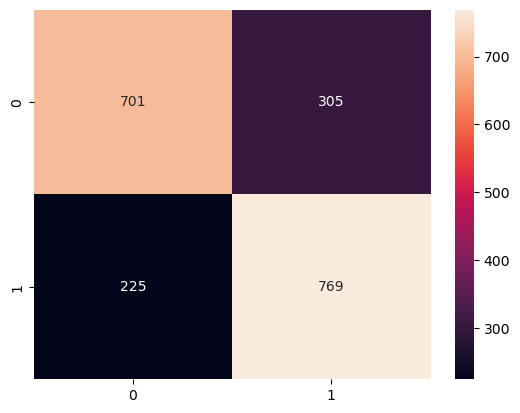

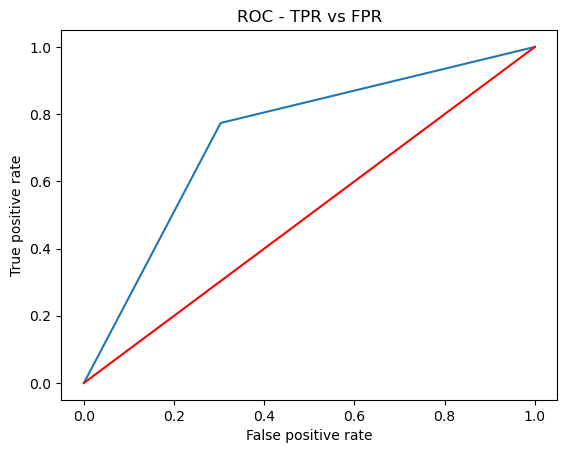

This is the confusion matrix and ROC curve of SVC


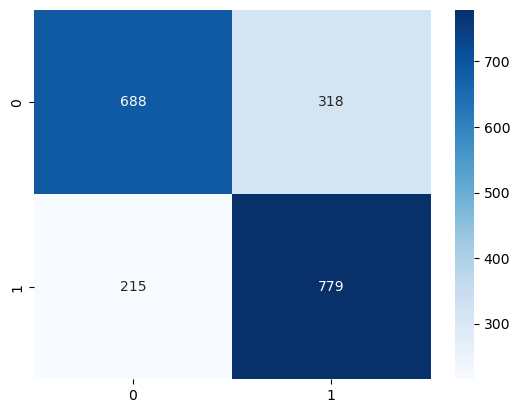

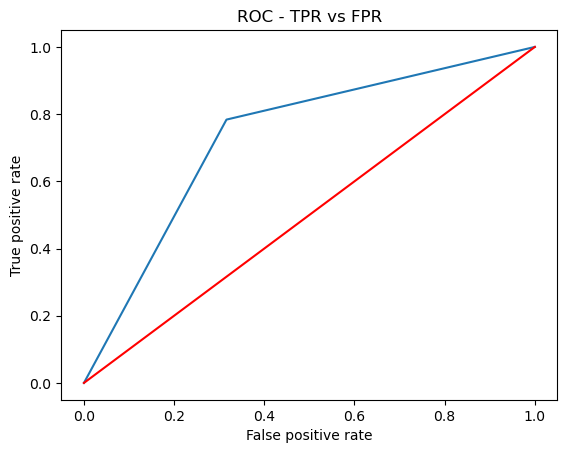

This is the confusion matrix and ROC curve of DecisionTreeClassifier


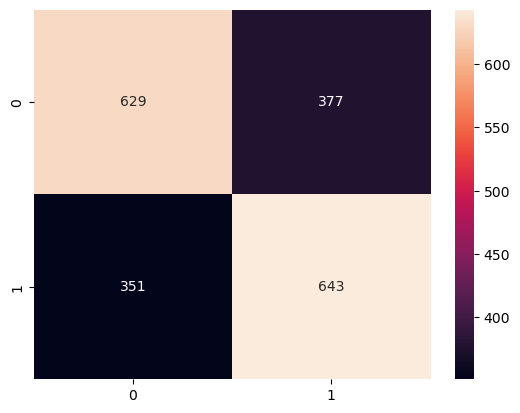

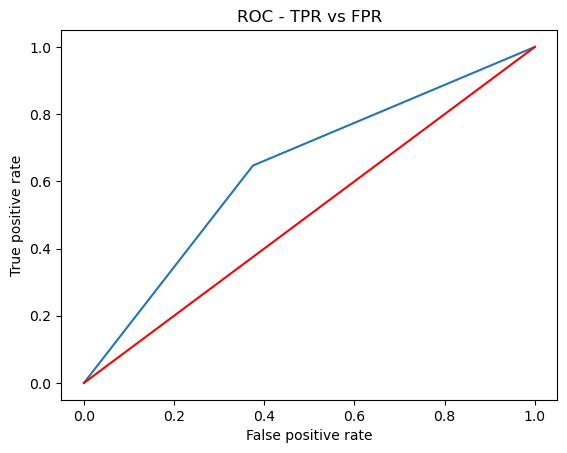

This is the confusion matrix and ROC curve of KNeighborsClassifier


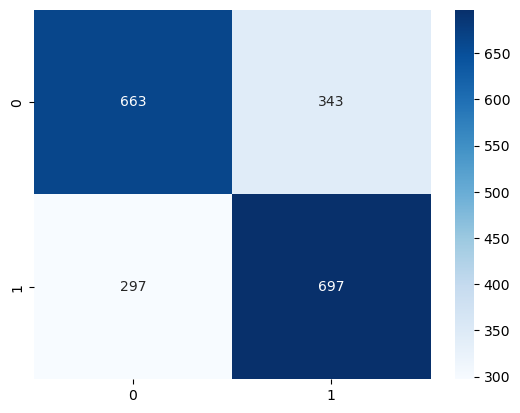

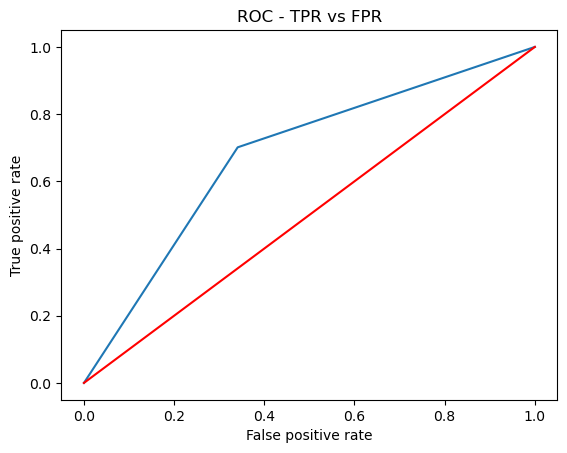

This is the confusion matrix and ROC curve of MLPClassifier


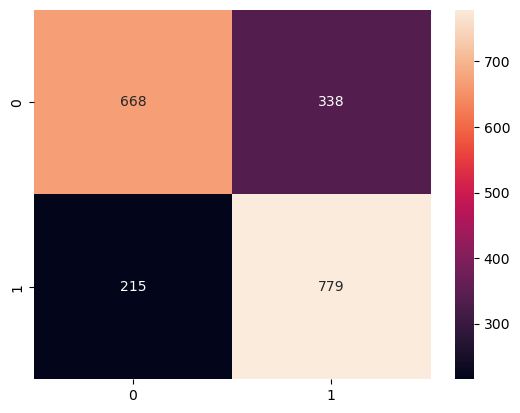

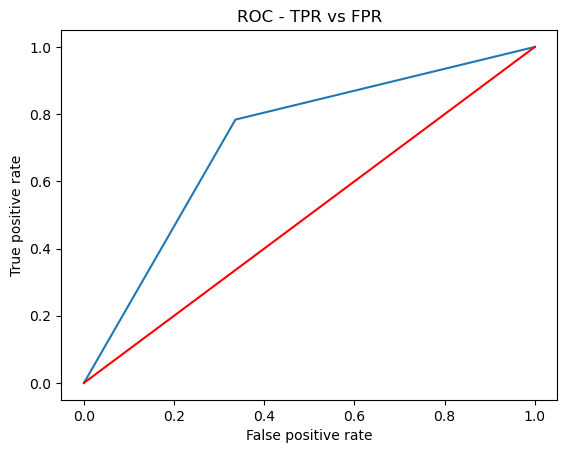

This is the confusion matrix and ROC curve of GaussianNB


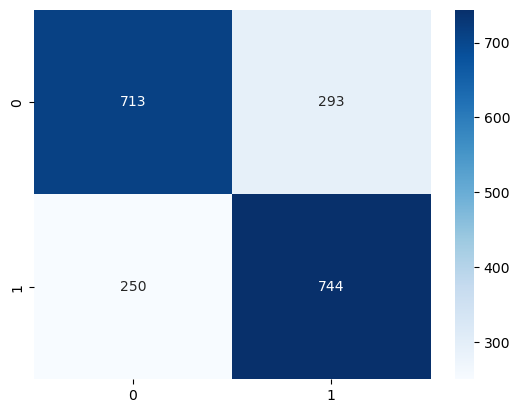

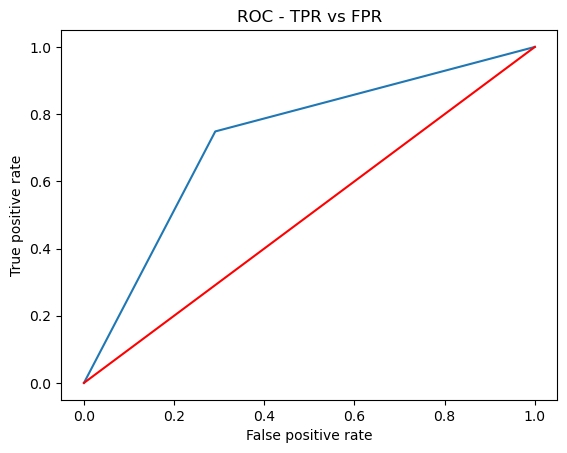

This is the confusion matrix and ROC curve of XGBClassifier


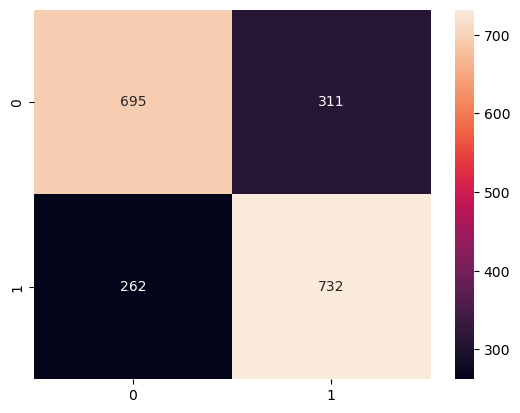

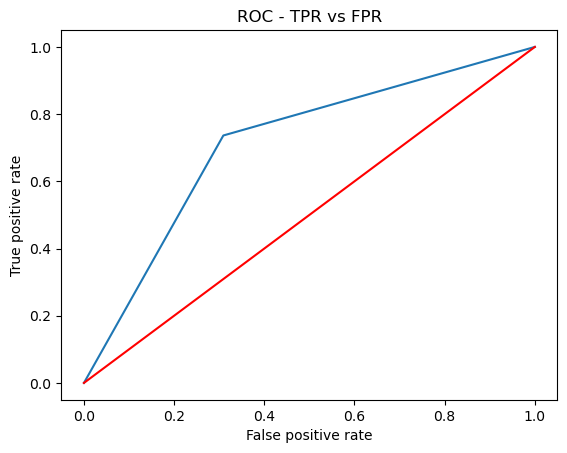

This is the confusion matrix and ROC curve of VotingClassifier


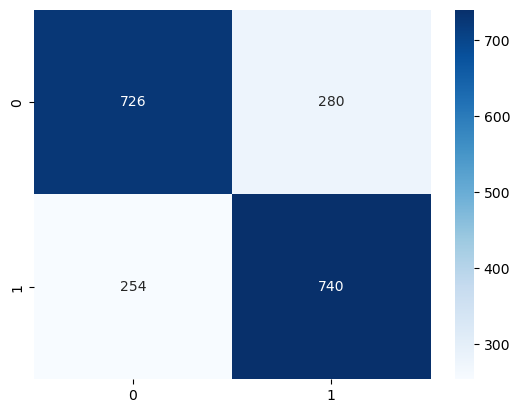

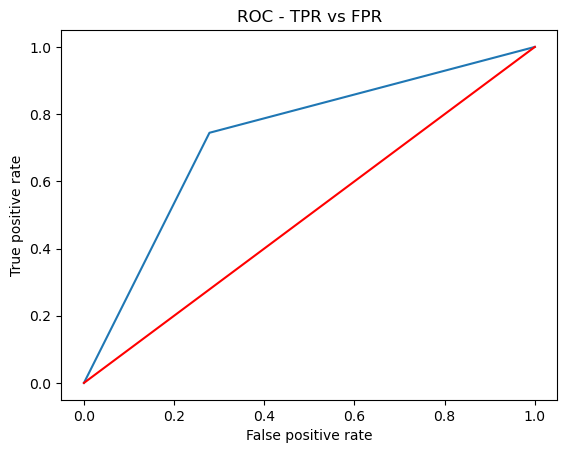

This is the confusion matrix and ROC curve of StackingClassifier


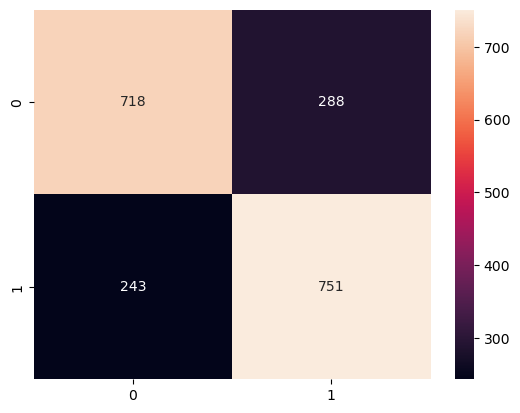

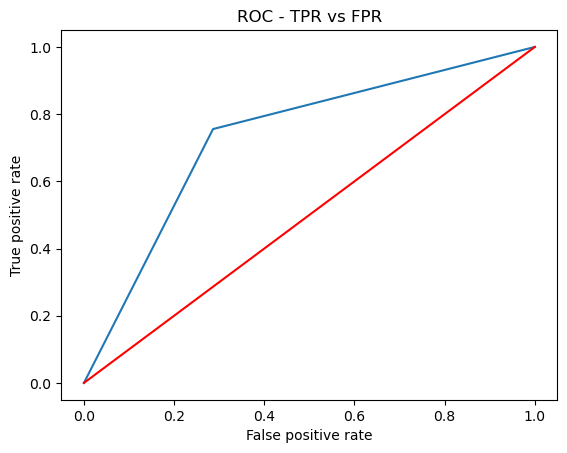

,Accuracy,Precision,Recall,F1
LogisticRegression,0.74,0.74,0.74,0.74
RandomForestClassifier,0.74,0.72,0.77,0.74
SVC,0.73,0.71,0.78,0.75
DecisionTreeClassifier,0.64,0.63,0.65,0.64
KNeighborsClassifier,0.68,0.67,0.7,0.69
MLPClassifier,0.72,0.7,0.78,0.74
GaussianNB,0.73,0.72,0.75,0.73
XGBClassifier,0.71,0.7,0.74,0.72
VotingClassifier,0.73,0.73,0.74,0.73
StackingClassifier,0.73,0.72,0.76,0.74


In [16]:
#Não usar bernoulli porque faz mais sentido para variaveis binarias
#from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import seaborn as sns 

rnd_clf=RandomForestClassifier(n_estimators=100)
log_clf=LogisticRegression()
svm_clf=SVC()
dtc_clf=DecisionTreeClassifier()
knn_clf=KNeighborsClassifier()
mpl_clf=MLPClassifier()
gnb_clf=GaussianNB()
xgb_clf = xgb.XGBClassifier(n_jobs=-1)
#Adicionar o resto dos modelos superviselearning menos o xgboost

voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)
                ,('dtc',dtc_clf),('knn',knn_clf),('mpl',mpl_clf),('gnb',gnb_clf),('xgb',xgb_clf)],
    voting='hard'
)

stacking_clf=StackingClassifier(
        estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)
                ,('dtc',dtc_clf),('knn',knn_clf),('mpl',mpl_clf),('gnb',gnb_clf),('xgb',xgb_clf)],
    final_estimator=LogisticRegression()
)
 
dataMetrics = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
for i, clf in enumerate([log_clf,rnd_clf,svm_clf,dtc_clf,knn_clf,mpl_clf,gnb_clf,xgb_clf,
                         voting_clf,stacking_clf], start=1):
    clf.fit(X_train_transf,y_train)
    y_pred=clf.predict(X_test_transf)   
    #DataFrame
    dataMetrics.loc[clf.__class__.__name__, ['Accuracy']] = metrics.accuracy_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['Precision']] = metrics.precision_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['Recall']] = metrics.recall_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['F1']] = metrics.f1_score(y_test, y_pred).round(2)
    
    print('This is the confusion matrix and ROC curve of '+str(clf.__class__.__name__))
    #Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    if i % 2 == 0:
        sns.heatmap(cf_matrix, annot=True, fmt='g');
    else:
        sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues');
    plt.show()
    #Generate the ROC AUC Curve
    roc_auc = roc_auc_score(y_test, y_pred)
    #ROC AUC Curve
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    plot_roc_curve(fpr,tpr)
    plt.show()
    
dataMetrics


This is the confusion matrix and ROC curve of LogisticRegression


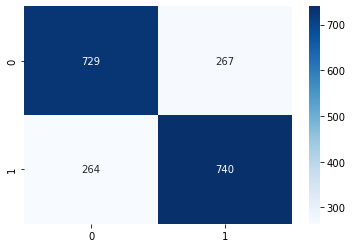

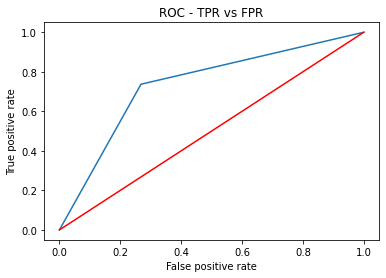

This is the confusion matrix and ROC curve of RandomForestClassifier


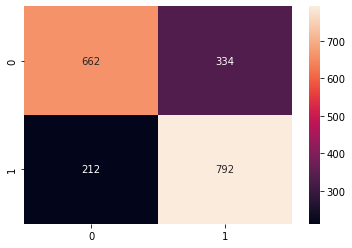

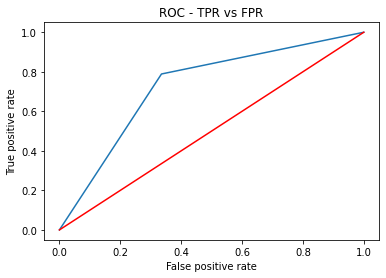

This is the confusion matrix and ROC curve of SVC


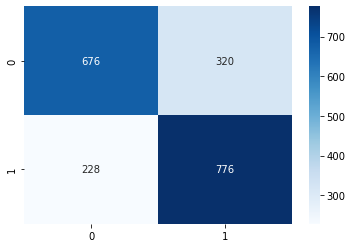

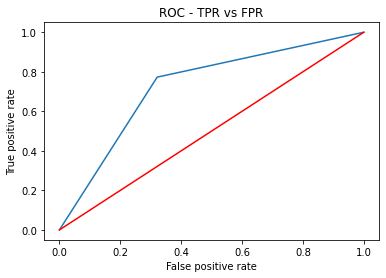

This is the confusion matrix and ROC curve of DecisionTreeClassifier


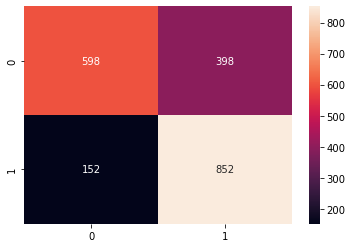

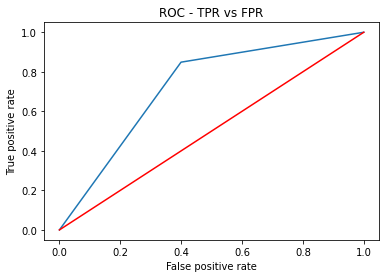

This is the confusion matrix and ROC curve of KNeighborsClassifier


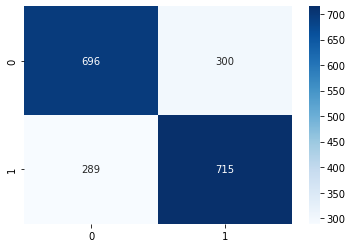

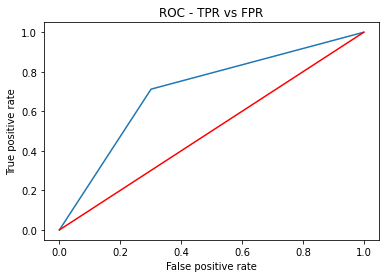

This is the confusion matrix and ROC curve of MLPClassifier


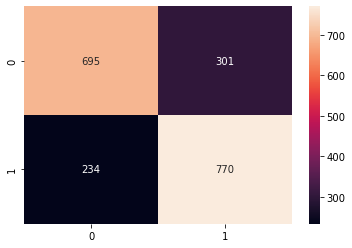

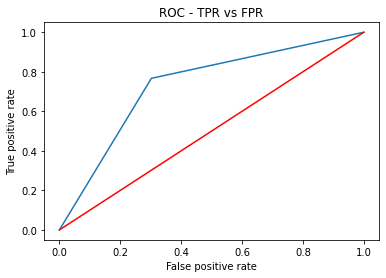

This is the confusion matrix and ROC curve of GaussianNB


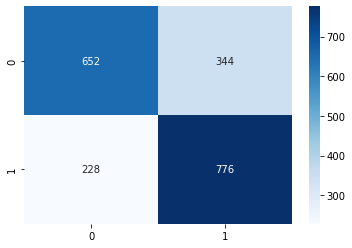

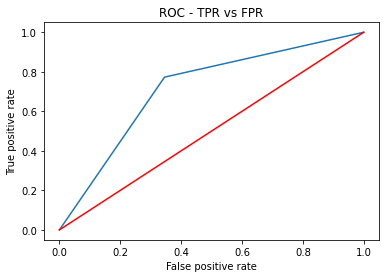

This is the confusion matrix and ROC curve of XGBClassifier


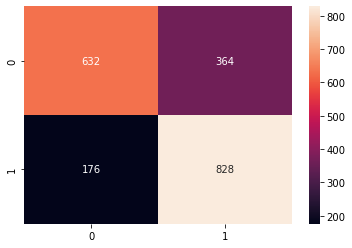

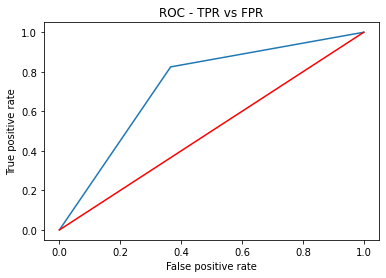

This is the confusion matrix and ROC curve of VotingClassifier


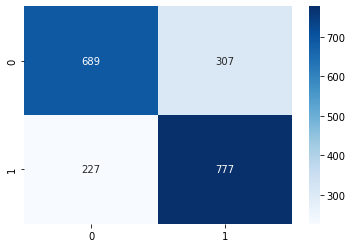

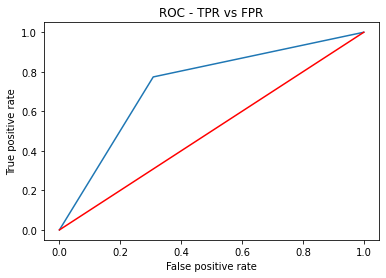

This is the confusion matrix and ROC curve of StackingClassifier


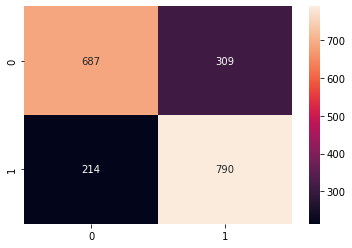

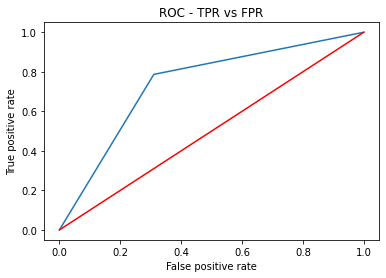

,Accuracy,Precision,Recall,F1
LogisticRegression,0.73,0.73,0.74,0.74
RandomForestClassifier,0.73,0.7,0.79,0.74
SVC,0.73,0.71,0.77,0.74
DecisionTreeClassifier,0.72,0.68,0.85,0.76
KNeighborsClassifier,0.71,0.7,0.71,0.71
MLPClassifier,0.73,0.72,0.77,0.74
GaussianNB,0.71,0.69,0.77,0.73
XGBClassifier,0.73,0.69,0.82,0.75
VotingClassifier,0.73,0.72,0.77,0.74
StackingClassifier,0.74,0.72,0.79,0.75


In [60]:
#Adicionar script dos classificador com hiperparametros
rnd_clf_best_params={'bootstrap': True,
                     'max_depth': 8,
                     'max_features': 'sqrt',
                    'min_samples_leaf': 6,
                     'min_samples_split': 20,
                     'n_estimators': 100}
log_clf_best_params={'C': 1}
svm_clf_best_params={'C': 1, 'kernel': 'rbf'}
dtc_clf_best_params={'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 10}
knn_clf_best_params={'leaf_size': 10,
                     'metric': 'euclidean',
                     'n_neighbors': 9,
                     'weights': 'distance'}
mpl_clf_best_params={'activation': 'logistic', 'hidden_layer_sizes': (8,), 'solver': 'adam'}
gnb_clf_best_params={}
#xgboost
xgb_clf_best_params={'gamma': 0,
                     'learning_rate': 0.01,
                     'max_depth': 3,
                     'n_estimators': 100,
                     'reg_alpha': 0.5,
                     'reg_lambda': 1,
                     'subsample': 0.8}
#############################
rnd_clf=RandomForestClassifier(**rnd_clf_best_params)
log_clf=LogisticRegression(**log_clf_best_params)
svm_clf=SVC(**svm_clf_best_params)
dtc_clf=DecisionTreeClassifier(**dtc_clf_best_params)
knn_clf=KNeighborsClassifier(**knn_clf_best_params)
mpl_clf=MLPClassifier(**mpl_clf_best_params)
gnb_clf=GaussianNB()
xgb_clf = xgb.XGBClassifier(**xgb_clf_best_params)
voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)
                ,('dtc',dtc_clf),('knn',knn_clf),('mpl',mpl_clf),('gnb',gnb_clf),('xgb',xgb_clf)],
    voting='hard'
)

stacking_clf=StackingClassifier(
        estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)
                ,('dtc',dtc_clf),('knn',knn_clf),('mpl',mpl_clf),('gnb',gnb_clf),('xgb',xgb_clf)],
    final_estimator=LogisticRegression()
)
###############################################
dataMetrics = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
for i, clf in enumerate([log_clf,rnd_clf,svm_clf,dtc_clf,knn_clf,mpl_clf,gnb_clf,xgb_clf,
                         voting_clf,stacking_clf], start=1):
    clf.fit(X_train_transf,y_train)
    y_pred=clf.predict(X_test_transf)   
    #DataFrame
    dataMetrics.loc[clf.__class__.__name__, ['Accuracy']] = metrics.accuracy_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['Precision']] = metrics.precision_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['Recall']] = metrics.recall_score(y_test, y_pred).round(2)
    dataMetrics.loc[clf.__class__.__name__, ['F1']] = metrics.f1_score(y_test, y_pred).round(2)
    
    print('This is the confusion matrix and ROC curve of '+str(clf.__class__.__name__))
    #Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    if i % 2 == 0:
        sns.heatmap(cf_matrix, annot=True, fmt='g');
    else:
        sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues');
    plt.show()
    #Generate the ROC AUC Curve
    roc_auc = roc_auc_score(y_test, y_pred)
    #ROC AUC Curve
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    plot_roc_curve(fpr,tpr)
    plt.show()
    
dataMetrics

# Confidence Interval

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

rnd_clf_best_params={'bootstrap': True,
                     'max_depth': 8,
                     'max_features': 'sqrt',
                    'min_samples_leaf': 6,
                     'min_samples_split': 20,
                     'n_estimators': 100}
log_clf_best_params={'C': 1}
svm_clf_best_params={'C': 1, 'kernel': 'rbf'}
dtc_clf_best_params={'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 10}
knn_clf_best_params={'leaf_size': 10,
                     'metric': 'euclidean',
                     'n_neighbors': 9,
                     'weights': 'distance'}
mpl_clf_best_params={'activation': 'logistic', 'hidden_layer_sizes': (8,), 'solver': 'adam'}
gnb_clf_best_params={}
#xgboost
xgb_clf_best_params={'gamma': 0,
                     'learning_rate': 0.01,
                     'max_depth': 3,
                     'n_estimators': 100,
                     'reg_alpha': 0.5,
                     'reg_lambda': 1,
                     'subsample': 0.8}

rnd_clf=RandomForestClassifier(**rnd_clf_best_params)
log_clf=LogisticRegression(**log_clf_best_params)
svm_clf=SVC(**svm_clf_best_params)
dtc_clf=DecisionTreeClassifier(**dtc_clf_best_params)
knn_clf=KNeighborsClassifier(**knn_clf_best_params)
mpl_clf=MLPClassifier(**mpl_clf_best_params)
gnb_clf=GaussianNB()
xgb_clf = xgb.XGBClassifier(**xgb_clf_best_params)

voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)
                ,('dtc',dtc_clf),('knn',knn_clf),('mpl',mpl_clf),('gnb',gnb_clf),('xgb',xgb_clf)],
    voting='hard'
)

stacking_clf=StackingClassifier(
        estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)
                ,('dtc',dtc_clf),('knn',knn_clf),('mpl',mpl_clf),('gnb',gnb_clf),('xgb',xgb_clf)],
    final_estimator=LogisticRegression()
)

modelos=[log_clf,rnd_clf,svm_clf,dtc_clf,knn_clf,mpl_clf,gnb_clf,xgb_clf,voting_clf,stacking_clf]

f1=np.zeros((len(modelos),50))
recall=np.zeros((len(modelos),50))

for j in range(0,50):
        #print(j)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        # Define the transformations to apply to the column
        transformer = ColumnTransformer([
                ('yeoj', PowerTransformer(), v_skew), #aplico transformação que corrige assimetria às assimétricas
                ('std', StandardScaler(), v_sym),     #aplico transformação às simétricas (sub média e dividir desvio padrao)
                ('oneh', OneHotEncoder(min_frequency=0.05,handle_unknown='ignore', sparse_output=False), v_cat_ord)
                ])

# Transform the data
        pfit = transformer.fit(X_train)

#Create dataframe with transformation
        categories= pfit.transformers_[2][1].categories_
        categories_out=pfit.transformers_[2][1].infrequent_categories_

        v_onehot=list(np.concatenate([(np.concatenate((np.array(j),
                       (np.array(['Other_Cat'+str(k)]) if categories_out[k] is not None else np.array([]))),axis=0)) 
                         for k,j in enumerate(
                         [np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0) 
                        for i in range(0,len(categories))]
                         )]))

#Transform train and test X
        X_train_transf = pd.DataFrame(pfit.transform(X_train),columns = (v_skew + v_sym+v_onehot)
                              ,index=X_train.index)

        X_test_transf = pd.DataFrame(pfit.transform(X_test),columns = (v_skew + v_sym+v_onehot)
                            ,index=X_test.index)
        
        for i, clf in enumerate(modelos):
                clf.fit(X_train_transf,y_train)
                y_pred=clf.predict(X_test_transf)  
                f1[i,j]=f1_score(y_test, y_pred)
                recall[i,j]=recall_score(y_test, y_pred)
                #print(i)
                #print(f1[0:3,:])

In [19]:
scores=round(pd.DataFrame(np.concatenate((f1.mean(axis=1).reshape(-1,1),np.quantile(f1,0.1,axis=1).reshape(-1,1)
               ,np.quantile(f1,0.9,axis=1).reshape(-1,1),recall.mean(axis=1).reshape(-1,1),
                np.quantile(recall,0.1,axis=1).reshape(-1,1)
               ,np.quantile(recall,0.9,axis=1).reshape(-1,1)),axis=1),index=dataMetrics.index,
                    columns=['average f1', 'f1 quantile 10%','f1 quantile 90%',
                            'average recall', 'recall quantile 10%','recall quantile 90%']),2)

round(scores,2).style.background_gradient(subset='average f1')

,average f1,f1 quantile 10%,f1 quantile 90%,average recall,recall quantile 10%,recall quantile 90%
LogisticRegression,0.730000,0.720000,0.740000,0.730000,0.710000,0.740000
RandomForestClassifier,0.750000,0.740000,0.760000,0.790000,0.770000,0.810000
SVC,0.740000,0.730000,0.750000,0.770000,0.750000,0.780000
DecisionTreeClassifier,0.750000,0.740000,0.760000,0.860000,0.830000,0.900000
KNeighborsClassifier,0.700000,0.690000,0.710000,0.710000,0.700000,0.730000
MLPClassifier,0.740000,0.730000,0.750000,0.760000,0.750000,0.780000
GaussianNB,0.720000,0.710000,0.730000,0.770000,0.750000,0.790000
XGBClassifier,0.750000,0.740000,0.760000,0.810000,0.790000,0.820000
VotingClassifier,0.740000,0.730000,0.760000,0.770000,0.750000,0.790000
StackingClassifier,0.740000,0.730000,0.750000,0.770000,0.750000,0.790000


In [26]:
log_clf=LogisticRegression(C=1)
svm_clf=SVC(C= 1,kernel= 'rbf')
dtc_clf=DecisionTreeClassifier(criterion= 'entropy',max_depth= 2,
                                  min_samples_leaf= 6,min_samples_split= 10)
dtc_clf1=DecisionTreeClassifier(criterion= 'entropy',max_depth= 1,
                                  min_samples_leaf= 6,min_samples_split= 10)

modelos_s=[log_clf,svm_clf,dtc_clf,dtc_clf1]
f1_s=np.zeros((len(modelos),50))
recall_s=np.zeros((len(modelos),50))

for j in range(0,50):
        #print(j)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        # Define the transformations to apply to the column 
        transformer = ColumnTransformer([
                ('yeoj', PowerTransformer(), v_skew), #aplico transformação que corrige assimetria às assimétricas 
                ('std', StandardScaler(), v_sym),     #aplico transformação às simétricas (sub média e dividir desvio padrao) 
                ('oneh', OneHotEncoder(min_frequency=0.05,handle_unknown='ignore', sparse_output=False), v_cat_ord)
                ])
# Transform the data 
        pfit = transformer.fit(X_train)
#Create dataframe with transformation 
        categories= pfit.transformers_[2][1].categories_
        categories_out=pfit.transformers_[2][1].infrequent_categories_
        v_onehot=list(np.concatenate([(np.concatenate((np.array(j),
                       (np.array(['Other_Cat'+str(k)]) if categories_out[k] is not None else np.array([]))),axis=0))
                         for k,j in enumerate(
                         [np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0)
                        for i in range(0,len(categories))]
                         )]))
#Transform train and test X
        X_train_transf = pd.DataFrame(pfit.transform(X_train),columns = (v_skew + v_sym+v_onehot),
                              index=X_train.index)
        X_test_transf = pd.DataFrame(pfit.transform(X_test),columns = (v_skew + v_sym+v_onehot),
                                index=X_test.index)
        X_train_transf = X_train_transf[['Asst_Reg']]
        X_test_transf = X_test_transf[['Asst_Reg']]

        for i, clf in enumerate(modelos_s):
                clf.fit(X_train_transf,y_train)
                y_pred=clf.predict(X_test_transf)
                f1_s[i,j]=f1_score(y_test, y_pred)
                recall_s[i,j]=recall_score(y_test, y_pred)
                #print(i)

In [27]:
scores_s=round(pd.DataFrame(np.concatenate((f1_s.mean(axis=1).reshape(-1,1),np.quantile(f1_s,0.1,axis=1).reshape(-1,1)
               ,np.quantile(f1_s,0.9,axis=1).reshape(-1,1),recall_s.mean(axis=1).reshape(-1,1),
                np.quantile(recall_s,0.1,axis=1).reshape(-1,1)
               ,np.quantile(recall_s,0.9,axis=1).reshape(-1,1)),axis=1),index=dataMetrics.index,
                    columns=['average f1', 'f1 quantile 10%','f1 quantile 90%',
                            'average recall', 'recall quantile 10%','recall quantile 90%']),2)

round(scores_s,2).style.background_gradient(subset='average f1')

,average f1,f1 quantile 10%,f1 quantile 90%,average recall,recall quantile 10%,recall quantile 90%
LogisticRegression,0.720000,0.710000,0.740000,0.730000,0.710000,0.740000
RandomForestClassifier,0.740000,0.720000,0.750000,0.770000,0.750000,0.780000
SVC,0.750000,0.730000,0.760000,0.840000,0.820000,0.890000
DecisionTreeClassifier,0.750000,0.740000,0.770000,0.860000,0.830000,0.900000
KNeighborsClassifier,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MLPClassifier,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GaussianNB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGBClassifier,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VotingClassifier,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StackingClassifier,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Unsupervised Learning

## PCA

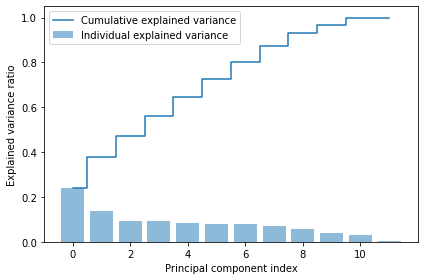

In [118]:
#Apply PCA to the training data to reduce the dimensionality
#ALWAYS STANDARDIZE
#VER SE VALE A PENA FAZER UNS GRAFICOS
#POR EXEMPLO
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=0.9999)

X_pca=pca.fit(X_train_transf[v_skew+v_sym])
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Use cross-validation to evaluate logistic regression with different numbers of principal components
pca = PCA()
logreg = LogisticRegression()

n_components = range(1, X_train_transf[v_skew+v_sym].shape[1]+1)
scores = []
display(X_train_transf[v_skew+v_sym].shape[1])

for n in n_components:
    pca.n_components = n
    X_train_pca = pca.fit_transform(X_train_transf[v_skew+v_sym])
    score = np.mean(cross_val_score(logreg, X_train_pca, y_train, cv=5, scoring='f1'))
    scores.append(score)

# Select the number of components that gives the highest cross-validation score
optimal_n_components = n_components[np.argmax(scores)]
display(scores)
#display(n_components)

# Train logistic regression model on full training set with optimal number of components
pca.n_components = optimal_n_components
display(optimal_n_components)

12

[0.5155674676611779,
 0.5124238752946376,
 0.5382678782729691,
 0.6505423263624617,
 0.6601273558276916,
 0.703316949709319,
 0.735382438801424,
 0.7351376389537059,
 0.7348512703396943,
 0.7342860697620757,
 0.736146431331423,
 0.7361469713592804]

12

In [120]:
pca = PCA(n_components=optimal_n_components)

X_pca=pca.fit(X_train_transf[v_skew+v_sym])

X_train_num_pca=pd.DataFrame(pca.transform(X_train_transf[v_skew+v_sym]),
                         columns=['pca_v'+str(i+1) for i in range (0,X_pca.n_components_)],
                        index=X_train_transf.index)

X_test_num_pca=pd.DataFrame(pca.transform(X_test_transf[v_skew+v_sym]),
                         columns=['pca_v'+str(i+1) for i in range (0,X_pca.n_components_)],
                        index=X_test_transf.index)

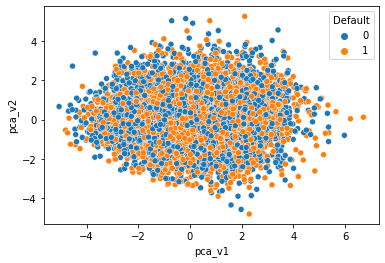

In [121]:
import seaborn as sns

df_pca=pd.concat([X_train_num_pca,pd.DataFrame(y_train)],axis=1)
#display(df_pca.head(5))

sns.scatterplot(x='pca_v1', y='pca_v2', hue='Default', data=df_pca);



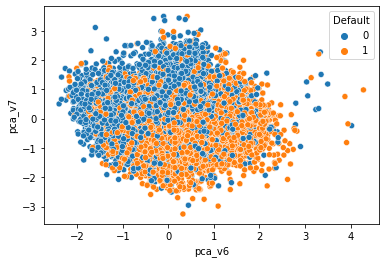

In [122]:
sns.scatterplot(x='pca_v6', y='pca_v7', hue='Default', data=df_pca);

,pca_v1,pca_v2,pca_v3,pca_v4,pca_v5,pca_v6,pca_v7,pca_v8,pca_v9,pca_v10,pca_v11,pca_v12,Default
Default,0.05,-0.03,-0.05,-0.31,0.13,0.28,-0.29,0.05,0.05,-0.01,0.04,-0.0,1.0


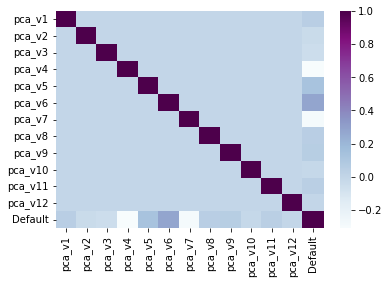

In [123]:
corr = df_pca.corr()
display(round(corr.iloc[[-1],:],2))

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cmap="BuPu");

In [124]:
#criar X com PCA
X_train_pca=pd.concat(
    [X_train_num_pca,
        X_train_transf[X_train_transf.columns[-(len(X_train_transf.columns)-len(v_skew+v_sym)):]]],
     axis=1)

X_test_pca=pd.concat(
    [X_test_num_pca,
        X_test_transf[X_test_transf.columns[-(len(X_test_transf.columns)-len(v_skew+v_sym)):]]],
     axis=1)

## Clustering

In [125]:
sse=[]
silhscores = []
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k_rng=range(1,15)
for k in k_rng:
    km=KMeans(n_clusters=k,n_init=10)
    km.fit(X_train_transf)
    sse.append(km.inertia_)
    if k>1:
        km_pred=km.predict(X_train_transf)
        silhscore = silhouette_score(X_train_transf, km_pred)
        silhscores.append(silhscore)
display(silhscores)    
sse

#--Lento

[0.13141926621087271,
 0.10488853998070613,
 0.1299980153325023,
 0.10942256717916399,
 0.09175878251570628,
 0.09345519658824318,
 0.08964714057092339,
 0.07994424677448653,
 0.07865288933357929,
 0.0767063239492428,
 0.0745987840499933,
 0.07776877892851732,
 0.07423516315003008]

[112934.69924999992,
 97268.19295147032,
 91271.13005591278,
 83672.75544156131,
 78616.88641422306,
 75493.32800917159,
 73332.22869106656,
 71251.96361092715,
 69539.85390802762,
 68195.93256246822,
 66965.93744224108,
 65957.309602856,
 64940.91501016547,
 64059.11694228809]

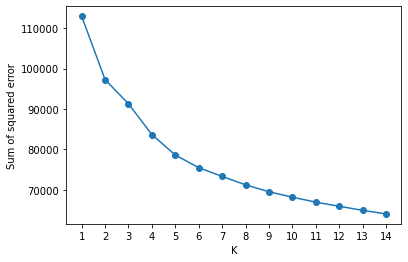

In [126]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.xticks(k_rng)
plt.plot(k_rng,sse, '-o');

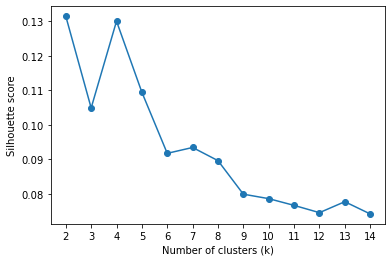

In [127]:
# Plot the silhouette scores
plt.plot(range(2, 15), silhscores, '-o')
plt.xticks(range(2, 15))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

In [128]:
#clusters identified by silhouette
k_silh=range(2,15)[np.array(silhscores).argmax()]
display('The silhouette score has chosen '+str(k_silh)+' clusters.')
km=KMeans(n_clusters=k_silh,n_init=10)
km_fit=km.fit(X_train_transf)

'The silhouette score has chosen 2 clusters.'

In [129]:
#Centros dos clusters
cluster=km_fit.predict(X_train_transf)
unique, counts = np.unique(cluster, return_counts=True)
display(pd.DataFrame(np.asarray((unique, counts)).T,columns=['cluster','no of obs']))

#km_fit.cluster_centers_

,cluster,no of obs
0,0,4079
1,1,3921


In [130]:
#create dataframe
ohe=OneHotEncoder(sparse=False)
display(pd.concat([X_train_transf,pd.DataFrame(ohe.fit_transform(km_fit.labels_.reshape(-1, 1)),
columns=['cluster'+str(i) for i in range(0,km_fit.labels_.max()+1)],
                    index=X_train_transf.index)],axis=1))


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,...,TX,Other_Cat1,credit card,debt consolidation,home improvement,Other_Cat2,3years,5years,cluster0,cluster1
9254,-1.334774,1.092357,-1.127564,0.227659,-0.506316,0.584969,0.281964,1.235479,-0.493504,-0.072648,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1561,-1.811082,-1.153314,1.809784,0.109571,0.321109,1.716920,1.106262,-0.073095,-0.493504,-0.072648,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1670,-0.027721,-0.823670,0.840675,0.227659,0.321109,1.611204,0.958722,0.479043,-0.493504,-0.072648,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6087,0.111834,1.092357,-0.772877,0.556355,1.011638,1.131229,1.213460,2.031281,-0.493504,-0.072648,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
6669,-0.132720,1.092357,-0.287255,0.503942,0.915041,-1.113158,0.547942,0.891172,-0.493504,-0.072648,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,-1.217342,0.844682,1.249902,0.556355,0.830982,1.534629,-0.760249,-1.400703,2.004608,-0.072648,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
5191,1.208996,-0.221974,-1.422034,-2.149551,0.223913,-0.918179,-0.701015,-0.006775,-0.493504,-0.072648,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
5390,1.355446,-0.221974,-0.349382,-0.277822,-0.361445,1.149716,-0.146947,0.025610,-0.493504,-0.072648,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
860,1.305811,1.092357,-0.772877,0.556355,-0.446628,-0.377745,0.005823,0.559100,-0.493504,-0.072648,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [136]:
# Create a grid search with cross-validation to find the best number of clusters
##from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline
#param_grid = {'kmeans__n_clusters': range(2, 15)}  # specify the range of cluster numbers to try
#grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
#grid_search.fit(X_train_transf, y_train)
from sklearn.model_selection import cross_validate
C=[0.001, 0.01, 0.1, 1, 10, 100]
scor=[]
for k in range(2,15):
    km=KMeans(n_clusters=k,n_init=10)
    km_fit=km.fit(X_train_transf)
    ohe=OneHotEncoder(sparse=False)
    X_cluster=pd.concat([X_train_transf,pd.DataFrame(ohe.fit_transform(km_fit.labels_.reshape(-1, 1)),
    columns=['cluster'+str(i) for i in range(0,km_fit.labels_.max()+1)],
                    index=X_train_transf.index)],axis=1)
    for i in C:
        logistic_regression = LogisticRegression(C=i)
        scor.append([k,i,cross_validate(logistic_regression, X_cluster, y_train, 
                           cv=5,scoring=['f1','recall'])['test_recall'].mean()])

In [146]:
np.array(scor)[np.array(scor)[:,2].argmax(),:]

k_cv=np.array(scor)[np.array(scor)[:,2].argmax(),0].astype(int)
C_cv=np.array(scor)[np.array(scor)[:,2].argmax(),1]
display(C_cv)

print('The best hyperparameters and f1 score are [k C f1]:'+str(np.array(scor)[np.array(scor)[:,2].argmax(),:]))

km=KMeans(n_clusters=k_cv,n_init=10)
km_fit=km.fit(X_train_transf)
ohe=OneHotEncoder(sparse=False)
X_train_cluster=pd.concat([X_train_transf,pd.DataFrame(ohe.fit_transform(km_fit.labels_.reshape(-1, 1)),
columns=['cluster'+str(i) for i in range(0,km_fit.labels_.max()+1)],
                    index=X_train_transf.index)],axis=1)
display(X_cluster.head(5))

cluster=km_fit.predict(X_train_transf)
#cluster=km_fit.predict(X_train_transf)
unique, counts = np.unique(cluster, return_counts=True)
display(pd.DataFrame(np.asarray((unique, counts)).T,columns=['cluster','no of obs']))

cluster_test=km_fit.predict(X_test_transf)
X_test_cluster=pd.concat([X_test_transf,pd.DataFrame(ohe.fit_transform(cluster_test.reshape(-1, 1)),
columns=['cluster'+str(i) for i in range(0,km_fit.labels_.max()+1)],
                    index=X_test_transf.index)],axis=1)
display(X_test_cluster.shape)

0.1

The best hyperparameters and f1 score are [k C f1]:[6.         0.1        0.73621632]


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,...,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13
9254,-1.334774,1.092357,-1.127564,0.227659,-0.506316,0.584969,0.281964,1.235479,-0.493504,-0.072648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1561,-1.811082,-1.153314,1.809784,0.109571,0.321109,1.716920,1.106262,-0.073095,-0.493504,-0.072648,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1670,-0.027721,-0.823670,0.840675,0.227659,0.321109,1.611204,0.958722,0.479043,-0.493504,-0.072648,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6087,0.111834,1.092357,-0.772877,0.556355,1.011638,1.131229,1.213460,2.031281,-0.493504,-0.072648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6669,-0.132720,1.092357,-0.287255,0.503942,0.915041,-1.113158,0.547942,0.891172,-0.493504,-0.072648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,cluster,no of obs
0,0,1653
1,1,1333
2,2,1220
3,3,1845
4,4,42
5,5,1907


(2000, 32)

In [148]:
lg=LogisticRegression()
lg.fit(X_train_transf,y_train)
y_pred=lg.predict(X_test_transf)
print('The f1 score for the standard lreg is '+str(f1_score(y_pred,y_test)))
lg.fit(X_train_pca,y_train)
y_pred=lg.predict(X_test_pca)
print('The f1 score for the lreg with PCA features is '+str(f1_score(y_pred,y_test)))
lg.fit(X_train_cluster,y_train)
y_pred=lg.predict(X_test_cluster)
print('The f1 score for the lreg with cluster encoded features added is '+str(f1_score(y_pred,y_test)))

display(X_train_pca)

The f1 score for the standard lreg is 0.7205955334987594
The f1 score for the lreg with PCA features is 0.7205955334987594
The f1 score for the lreg with cluster encoded features added is 0.7215064420218038


,pca_v1,pca_v2,pca_v3,pca_v4,pca_v5,pca_v6,pca_v7,pca_v8,pca_v9,pca_v10,...,Florida,Newyork,TX,Other_Cat1,credit card,debt consolidation,home improvement,Other_Cat2,3years,5years
9254,-0.389751,-1.201087,-0.062559,-0.566011,0.886364,-0.326664,-1.325623,0.597165,0.424575,1.521208,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1561,-1.642185,0.482694,-0.610463,-1.694802,-0.591389,2.216358,-0.046006,0.097524,-0.928618,0.320731,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1670,-1.758583,0.264866,-0.643903,0.030900,-1.507538,1.092269,-0.021715,-0.027046,-1.047291,0.417826,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6087,-2.109439,-1.764742,0.295078,-0.063518,0.139713,-0.993025,-0.329678,0.181064,-0.359376,1.214399,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6669,-0.525665,-1.552459,0.219151,-0.676551,-0.498541,-0.995930,-0.047172,0.502969,0.795712,-0.399932,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,-0.469944,1.998436,1.315712,-2.227893,1.461516,0.130356,-0.143146,-1.350084,-0.264231,0.236817,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5191,2.175753,-1.418213,0.208383,1.044418,0.703189,-0.984781,0.438085,-0.181521,-1.172068,-0.304255,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
5390,0.022579,0.349214,-0.519347,0.783676,-1.519033,-0.424732,0.183139,0.050294,-1.142147,0.952839,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
860,-0.108654,-0.294911,-0.357380,0.842365,-1.362024,-1.551850,-0.282818,0.560898,0.484313,0.389173,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# Models hyperparameter tuning

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LogisticRegression()
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test_transf)

## SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
#model = LinearSVC(loss='hinge',max_iter=10000)
model = SVC(max_iter=10000)
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'kernel': ['linear', 'rbf','sigmoid']}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1',n_jobs=-1)

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid
param_grid = {
    'max_depth': [2, 3 ,5, 8, 13, 21],
    'min_samples_leaf': [ 6, 8],
    'min_samples_split': [ 10, 20],
    'criterion': ['gini', 'entropy']
}

tree_clf=DecisionTreeClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5,scoring='f1')

# Fit the grid search to the training data
tree_clf_cv=grid_search.fit(X_train_transf, y_train)

In [ ]:
# Print the best parameters
display(tree_clf_cv.best_score_)
print(tree_clf_cv.best_params_)
best_tree_params=tree_clf_cv.best_params_
best_tree=DecisionTreeClassifier(**best_tree_params)
best_tree

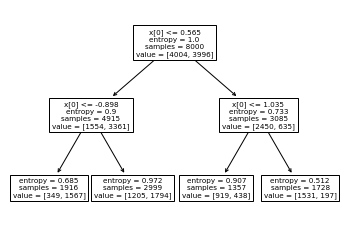

In [58]:
from sklearn.tree import plot_tree
dtc_clf=DecisionTreeClassifier(**dtc_clf_best_params)
plot_tree(dtc_clf.fit(X_train_transf, y_train));

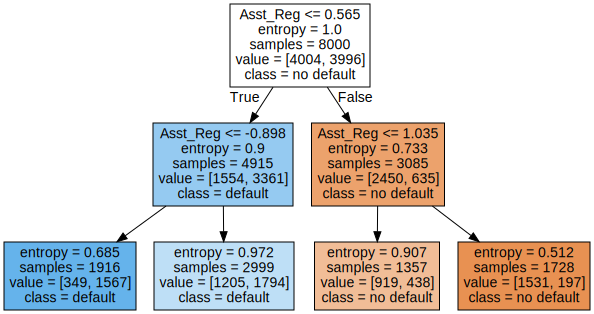

In [59]:
import graphviz
from sklearn.tree import export_graphviz

dot_data=export_graphviz(dtc_clf,feature_names=X_train_transf.columns,
                         class_names=['no default','default'],
                         filled=True)

graph=graphviz.Source(dot_data)
graph

## Naive Bayes

In [ ]:
#não precisamos de adicionar hiperparametro devido ao facto de já termos a variancia normalizada das features
#no limite, hiperparametros só no pré processamento, ajustadando no no de bins 
from sklearn.preprocessing import KBinsDiscretizer
est=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='quantile')
est.fit(X_train_tranf)
Xt_train=est.transform(X_train_transf)
Xt_test=est.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
mnNB=MultinomialNB()
mnNB.fit(Xt_train,y_train)
y_pred=mnNB.predict(Xt_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Create the pipeline
pipeline = Pipeline([
    ('discretizer', KBinsDiscretizer(encode='ordinal',strategy='quantile')),
    ('classifier', MultinomialNB())
])

# Create the parameter grid
param_grid = {
    'discretizer__n_bins': [3, 5, 7, 9]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

display(grid_search.best_estimator_)

# Evaluate the best model on the test data
accuracy = best_model.score(X_test_transf, y_test)
print('Test accuracy:', accuracy)


In [ ]:
from sklearn.naive_bayes import GaussianNB
gNB=GaussianNB()
gNB.fit(X_train_transf,y_train)
y_pred=gNB.predict(X_test)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid={'n_estimators':[int(x) for x in np.linspace(10,100,4)],
            'max_features':['auto','sqrt'],
            'max_depth': [2, 3 ,5, 8, 13, 21],
            'min_samples_leaf': [6, 8],
            'min_samples_split': [10, 20],
            'bootstrap':[True,False]
}

rf_clf=RandomForestClassifier()

# Create the grid search object
rf_clf_gs = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5,scoring='f1',n_jobs=-1)

# Fit the grid search to the training data
rf_clf_cv=rf_clf_gs.fit(X_train_transf, y_train)

In [ ]:
# Print the best parameters
display(rf_clf_cv.best_score_)
best_rf_params=rf_clf_cv.best_params_
display(best_rf_params)
best_rf=RandomForestClassifier(**best_rf_params)
best_rf

## Kneighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create the parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'leaf_size': [10, 30, 50, 70]
}

# Create the k-NN classifier
knn = KNeighborsClassifier()

# Create the grid search object
knn_gs = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5,scoring='f1',n_jobs=-1)


# Fit the grid search to the training data
knn_clf_cv=knn_gs.fit(X_train_transf, y_train)

In [ ]:
# Print the best parameters
display(knn_clf_cv.best_score_)
best_knn_params=knn_clf_cv.best_params_
display(best_knn_params)
best_knn=KNeighborsClassifier(**best_knn_params)
best_knn

## Xgboost

In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
# Define the parameters for the XGBoost model
xgbo_param_grid = {
    'max_depth': [3 ,5, 8],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50,100],
    'gamma': [0, 0.5, 1],
    'subsample': [0.5, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [ 0.5, 1]
}

# Create the k-NN classifier
xgbo = xgb.XGBClassifier(n_jobs=-1,verbose=10)

# Create the grid search object
xgbo_gs = GridSearchCV(estimator=xgbo, param_grid=xgbo_param_grid, cv=5,scoring='f1',n_jobs=-1,verbose=10)

# Fit the grid search to the training data
xgbo_clf_cv=xgbo_gs.fit(X_train_transf, y_train,verbose=10)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[09:01:46] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.



In [16]:
# Print the best parameters
display(xgbo_clf_cv.best_score_)
best_xgbo_params=xgbo_clf_cv.best_params_
display(best_xgbo_params)
best_xgbo=xgb.XGBClassifier(**best_xgbo_params)
best_xgbo

0.7523584628308703

{'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0.5,
 'reg_lambda': 1,
 'subsample': 0.8}

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Redes neuronais

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


mlp_param_grid = {'hidden_layer_sizes': [(6,),(8,),(5,),(10,), (20,), (30,), (40,)],
              'solver': ['adam', 'sgd'],
              'activation': ['relu', 'tanh','logistic']}

mlp=MLPClassifier(max_iter=2000)

# Create the grid search object
mlp_gs = GridSearchCV(estimator=mlp, param_grid=mlp_param_grid, cv=5,scoring='f1',n_jobs=-1)

# Fit the grid search to the training data
mlp_clf_cv=mlp_gs.fit(X_train_transf, y_train)

In [ ]:
# Print the best parameters
display(mlp_clf_cv.best_score_)
best_mlp_params=mlp_clf_cv.best_params_
display(best_mlp_params)
best_mlp=MLPClassifier(**best_mlp_params)
best_mlp

# Combinação de modelos

In [ ]:
# Fit different models and evaluate their performance
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

for model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{model.__class__.__name__}: {accuracy:.2f}")
    
    #STACKING
# Define the base models
base_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

# Define the second-level model
meta_model = LogisticRegression()

# Define the stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = stacking_model.predict(X_test)

# Evaluate the model
accuracy = stacking_model.score(X_test, y_test)
print("Accuracy:", accuracy)


In [57]:

estimatorsArray=[
            ('rfc',RandomForestClassifier(**rnd_clf_best_params)),
            ('svc', SVC(**svm_clf_best_params)),
            ('lr', LogisticRegression(**log_clf_best_params))]


# criar o pipeline com os classificadores
fvPipeLine = Pipeline(
    steps=[
        ("vtclf", 
            VotingClassifier(estimators= estimatorsArray, voting='hard')
        )
    ]
) 

# treinar e avaliar os classificadores no pipeline
fvPipeLine.fit(X_train_transf, y_train) 
y_pred = fvPipeLine.predict(X_test_transf) 
printCustomMetrics(y_test, y_pred)


Accuracy: 0.73
Precision: 0.69
Recall: 0.78
f1: 0.73


In [58]:

estimatorsArray=[
            ('rfc',RandomForestClassifier(**rnd_clf_best_params)),
            ('svc', SVC(**svm_clf_best_params)),
            ('lr', LogisticRegression(**log_clf_best_params))]

# Define the second-level model
meta_model = LogisticRegression()

# criar o pipeline com os classificadores
fsPipeLine = Pipeline(
    steps=[
        ("stclf", 
            StackingClassifier(estimators= estimatorsArray,final_estimator=meta_model, cv=5)
        )
    ]
) 

# treinar e avaliar os classificadores no pipeline
fsPipeLine.fit(X_train_transf, y_train) 
y_pred = fvPipeLine.predict(X_test_transf) 
printCustomMetrics(y_test, y_pred)



Accuracy: 0.73
Precision: 0.69
Recall: 0.78
f1: 0.73
